# Sequential CRM Experiments

## Reference works
- ref paper: https://arxiv.org/pdf/1502.02362.pdf
- ref code & data: https://www.cs.cornell.edu/~adith/POEM/
- recent paper (ICML'18): http://proceedings.mlr.press/v80/wu18g/wu18g.pdf
- recent paper using vision tasks: https://arxiv.org/pdf/1806.11500v6.pdf

TODO:
1. DONE - fix pi0 to be bad enough
1. DONE - make sure propensities are not all 0
1. DONE - add check for propensity overfitting
1. SEEMS OK - fix optim to work correctly -- but POEM cannot work with LBFG-S (see paper)

In [1]:
import sys
import time

In [2]:
import numpy as np

In [28]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [4]:
import matplotlib.pyplot as plt

In [5]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines
from crm_dataset import CRMDataset
from crm_model import Model
from tracing_utils import LossHistory

---
### Loading dataset

In [6]:
dataset_name='scene'
# dataset_name='yeast'
# dataset_name='tmc2007'

X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name)

X_train: (1805, 295) y_train: (1805, 6)


### Baselines & Skylines

In [7]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train)

In [8]:
sampling_probas = pi0.predict_proba(X_train)
sampling_probas = np.array([_[:,1] for _ in sampling_probas]).T 

In [9]:
sampling_probas.min(axis=0)

array([0.0027083 , 0.00164241, 0.00791265, 0.000771  , 0.00978938,
       0.00021801])

In [10]:
log_props_per_instance = jnp.log(sampling_probas).sum(axis=1)
n_zero_props = (jnp.exp(log_props_per_instance) == 0).astype(int).sum()
print(n_zero_props, '/', sampling_probas.shape[0], 'train instances have 0 propensity')
assert (n_zero_props / sampling_probas.shape[0]) < .1

0 / 1805 train instances have 0 propensity


# The Experiment

In [11]:
n_train = X_train.shape[0]
n_replays = 10

n = 100
rollouts = [n]
while True:
    n = 2*n
    if n > n_train * n_replays:
        break
    rollouts += [int(n)]
rollouts = sorted(rollouts)
print("rollout times:", rollouts)

rollout times: [100, 200, 400, 800, 1600, 3200, 6400, 12800]


In [12]:
dynamic_ips_losses = []
myopic_ips_losses = []

for _ in range(10):
    

    dynamic_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    dynamic_crm_dataset = CRMDataset()
    dynamic_loss_history = LossHistory("Dynamic", X_test, y_test)
    dynamic_sampling_probas = None
    
    myopic_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    myopic_loss_history = LossHistory("Myopic", X_test, y_test)
    myopic_sampling_probas = None
    
    last_rollout_point = 0

    for rollout_point in rollouts:

        print('*'*30, 'ROLLOUT %d/%d'% (rollout_point, n_train), '*'*30, file=sys.stderr)

        # current slice of dataset
        if rollout_point >= n_train:
            rollout_point = rollout_point % n_train
            last_rollout_point = 0
        X = X_train[last_rollout_point:rollout_point,:]
        y = y_train[last_rollout_point:rollout_point,:]
        last_rollout_point = rollout_point

        # action probas
        if dynamic_sampling_probas is None:
            dynamic_sampling_probas = pi0.predict_proba(X)
            dynamic_sampling_probas = np.array([_[:,1] for _ in dynamic_sampling_probas]).T
        else:
            dynamic_sampling_probas = dynamic_model.predict_proba(X, y)
            
        # crm dataset
        np.random.seed(_*42) # controlling action randomness
        dynamic_crm_dataset.update_from_supervised_dataset(X, y, dynamic_sampling_probas, n_samples=1)
        
        # optimize
        dynamic_model.fit(
            dynamic_crm_dataset, beta_start=dynamic_model.beta,
            verbose = 0
        )

        # record
        dynamic_loss_history.update(dynamic_model, dynamic_crm_dataset)
        dynamic_loss_history.show_last()
        
        # myopic
        # action probas
        if myopic_sampling_probas is None:
            myopic_sampling_probas = pi0.predict_proba(X)
            myopic_sampling_probas = np.array([_[:,1] for _ in myopic_sampling_probas]).T
        else:
            myopic_sampling_probas = myopic_model.predict_proba(X, y)
        
        np.random.seed(_*42) # controlling action randomness
        myopic_crm_dataset = CRMDataset().update_from_supervised_dataset(X, y, myopic_sampling_probas, n_samples=1)
        myopic_model.fit(
            myopic_crm_dataset, beta_start=myopic_model.beta, 
            verbose = 0
        )
        myopic_loss_history.update(myopic_model, myopic_crm_dataset)
        myopic_loss_history.show_last()


    dynamic_ips_losses += [dynamic_loss_history.hamming_loss[-1]]
    myopic_ips_losses += [myopic_loss_history.hamming_loss[-1]]
    print(file=sys.stderr)


****************************** ROLLOUT 100/1805 ******************************
< Dynamic | Ham. loss: 0.30015 | CRM loss: 0.16667 |beta|=24.56 n=100 |A|=281 |R|=381 >
< Myopic | Ham. loss: 0.30015 | CRM loss: 0.16667 |beta|=24.56 n=100 |A|=281 |R|=381 >
****************************** ROLLOUT 200/1805 ******************************
< Dynamic | Ham. loss: 0.30015 | CRM loss: 0.16667 |beta|=24.56 n=200 |A|=709 |R|=481 >
< Myopic | Ham. loss: 0.30015 | CRM loss: 0.83333 |beta|=24.56 n=100 |A|=428 |R|=100 >
****************************** ROLLOUT 400/1805 ******************************
< Dynamic | Ham. loss: 0.30015 | CRM loss: 0.16667 |beta|=24.56 n=400 |A|=1563 |R|=681 >
< Myopic | Ham. loss: 0.30015 | CRM loss: 0.83333 |beta|=24.56 n=200 |A|=854 |R|=200 >
****************************** ROLLOUT 800/1805 ******************************
< Dynamic | Ham. loss: 0.30015 | CRM loss: 0.16667 |beta|=24.56 n=800 |A|=3247 |R|=1081 >
< Myopic | Ham. loss: 0.30015 | CRM loss: 0.83333 |beta|=24.56 n=400

In [14]:
result_table(dataset_name, pi0, pistar, X_test, y_test, 
             dynamic_ips_loss=np.mean(dynamic_ips_losses))

Baseline -- crm paper: 0.257 -- vrcrm paper: 0.315 -- ours: 0.352
IPS      -- crm paper: 0.199 -- vrcrm paper: 0.225
Dynamic IPS                                        -- ours: 0.269
POEM     -- crm paper: 0.195 -- vrcrm paper: 0.195
Skyline  -- crm paper: 0.110 -- vrcrm paper: 0.237 -- ours: 0.144


In [20]:
np.array(myopic_ips_losses) - np.array(dynamic_ips_losses)

array([ 0.00000000e+00, -8.81016346e-03,  0.00000000e+00, -2.22622976e-02,
        0.00000000e+00, -5.03613683e-03,  0.00000000e+00, -1.97626205e-04,
       -2.41186534e-02,  5.51363889e-06])

### Insights

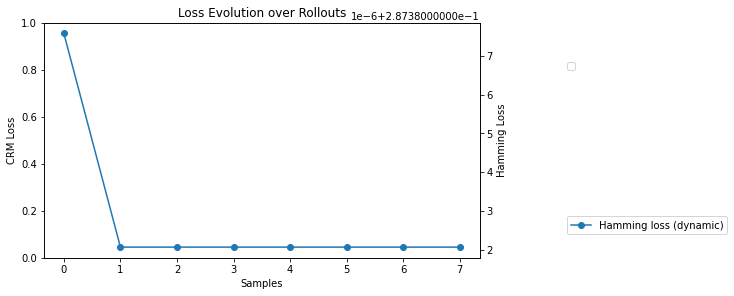

In [22]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(10,4))
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Samples')
ax.set_ylabel('CRM Loss')
# ax.plot(myopic_loss_history.crm_loss, 'o--', label='CRM loss (myopic)')
# ax.plot(dynamic_loss_history.crm_loss, 'o--', label='CRM loss (dynamic)')
# ax.plot(myopic_loss_history.n_samples, myopic_loss_history.unif_crm_loss, 'o--', label='unif. CRM loss (dynamic)')
ax.legend(loc=(1.2, .8))
ax2 = ax.twinx()
# ax2.plot(myopic_loss_history.hamming_loss, 'o-', label='Hamming loss (myopic)')
ax2.plot(dynamic_loss_history.hamming_loss, 'o-', label='Hamming loss (dynamic)')
ax2.set_ylabel('Hamming Loss')
ax2.legend(loc=(1.2, .1))

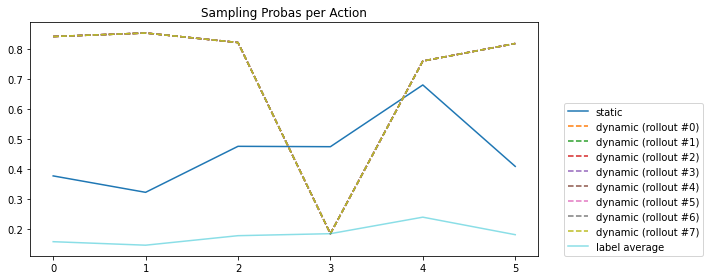

In [26]:
plt.figure(figsize=(10,4))
plt.title('Sampling Probas per Action')
plt.plot(sampling_probas.mean(axis=0), label='static')
for i, beta in enumerate(dynamic_loss_history.betas):
    m = Model(beta)
    plt.plot(m.predict_proba(X_test, y_test).mean(axis=0),'--', label='dynamic (rollout #%d)' % i)
plt.plot(y_test.mean(axis=0), label='label average', alpha=.5)
plt.legend(loc=(1.05, 0))
plt.tight_layout()

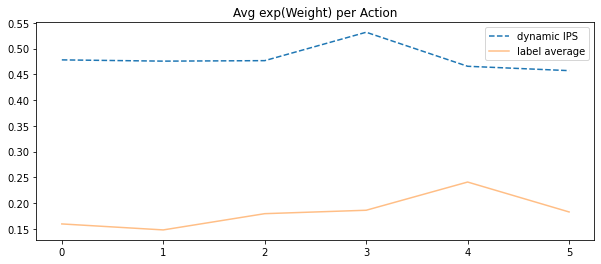

In [34]:
plt.figure(figsize=(10,4))
plt.title('Avg exp(Weight) per Action')
plt.plot(jexpit(dynamic_model.beta.mean(axis=0)),'--', label='dynamic IPS')
# plt.plot(jexpit(ips_model.beta.mean(axis=0)),'--', label='IPS')
# plt.plot(jexpit(poem_model.beta.mean(axis=0)),'--', label='POEM')
plt.plot(y_test.mean(axis=0), label='label average', alpha=.5)
plt.legend()

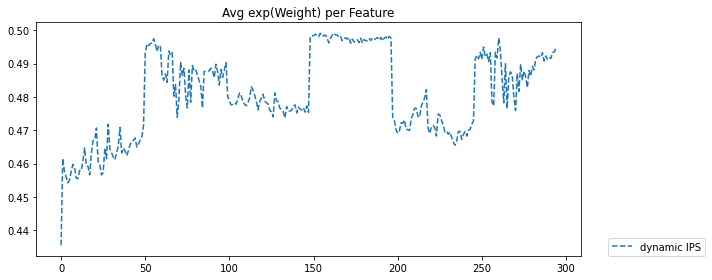

In [33]:
plt.figure(figsize=(10,4))
plt.title('Avg exp(Weight) per Feature')
plt.plot(jexpit(dynamic_model.beta.mean(axis=1)),'--', label='dynamic IPS')
# plt.plot(jexpit(ips_model.beta.mean(axis=1)),'--', label='IPS')
# plt.plot(jexpit(poem_model.beta.mean(axis=1)),'--', label='POEM')
plt.legend(loc=(1.05, 0))
plt.tight_layout()